<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from time import time
from pandas.api.types import CategoricalDtype
import logging
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
RANDOM_STATE=42
TEST_SIZE=0.1
cv = TimeSeriesSplit(n_splits=5)

## Загрузка данных

In [3]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет, теперь посмотрим дублируются ли времена

In [6]:
df.index.duplicated().sum()

0

Ресемплируем количество заказов по одному часу

In [7]:
df = df.resample('1H').sum()

**Промежуточные итоги**
- Были загружены исходные данные
- Отработка пропусков и дубликатов не требуется
- Было проведено ресемплирование данных

## Анализ данных

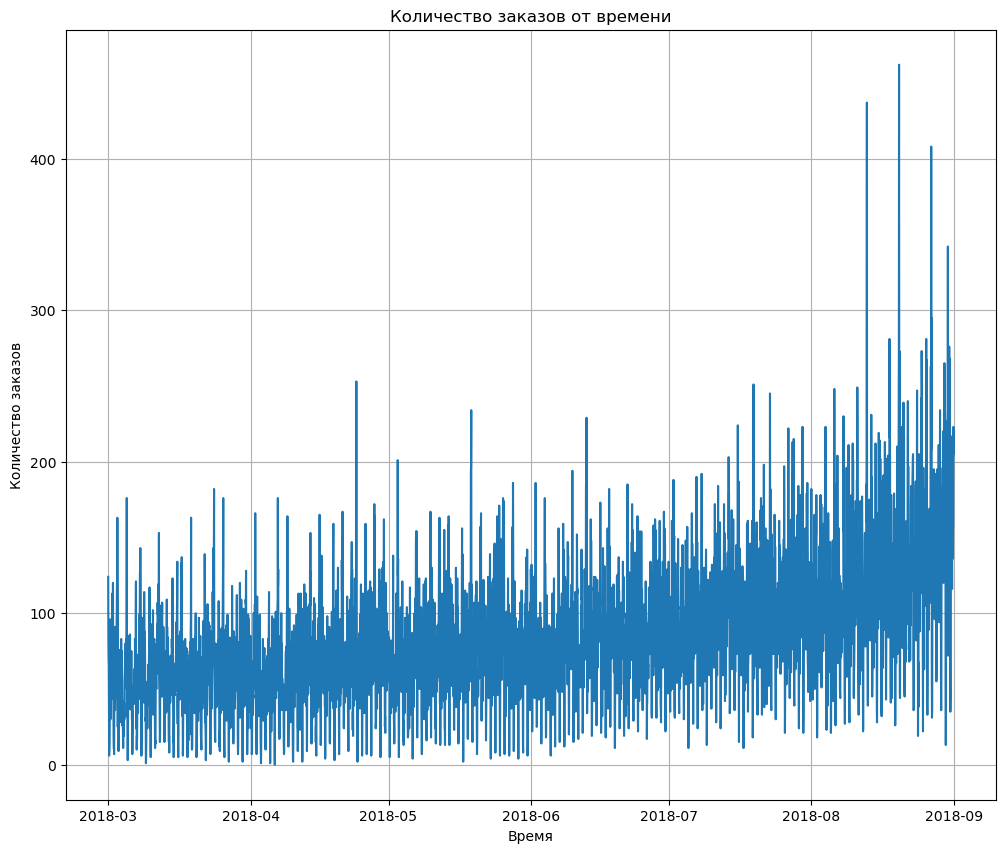

In [8]:
plt.figure(figsize=(12,10))
sns.lineplot(data=df, x=df.index, y='num_orders')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов от времени')
plt.grid()

Пиковые значения количества заказов приходится на конец летнего сезона, когда скорее всего большое количество людей прилетают с отпусков

In [9]:
decompose = seasonal_decompose(df.copy(deep=True))

In [10]:
def plot(data, title):
    plt.figure(figsize=(12,10))
    sns.lineplot(data=data)
    plt.grid()
    plt.title(title)

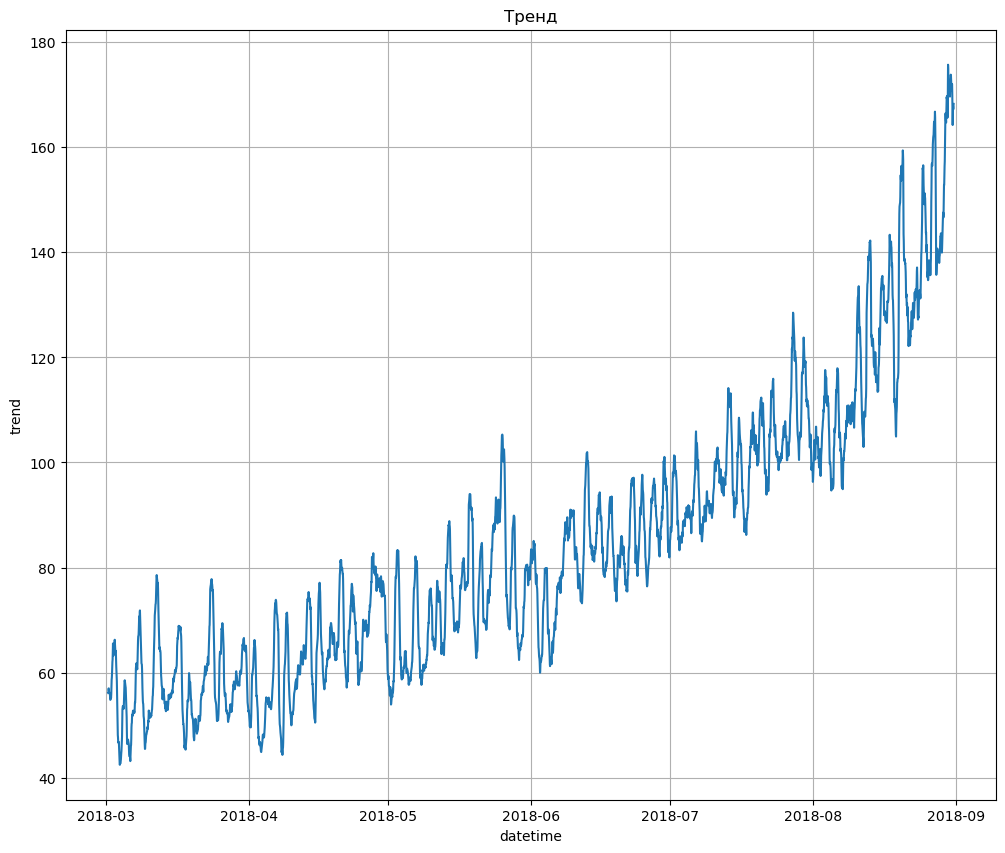

In [11]:
plot(decompose.trend, 'Тренд')

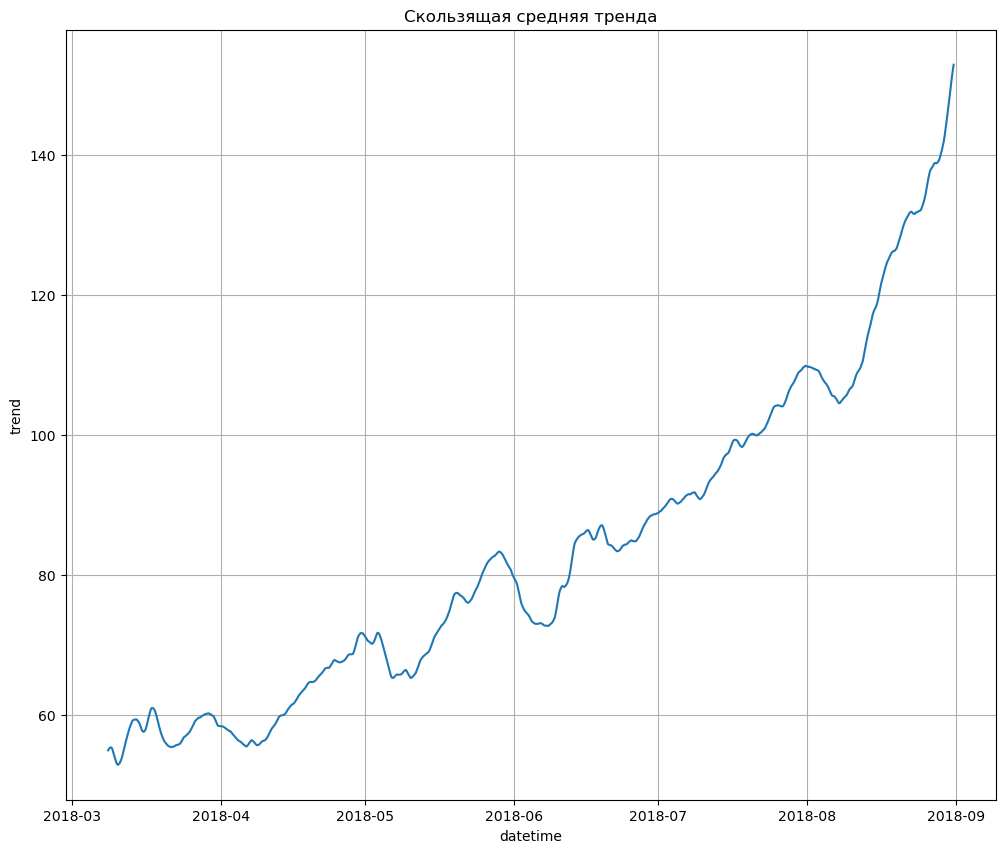

In [12]:
plot(decompose.trend.rolling(24*7).mean(), 'Скользящая средняя тренда')

Восходящий тренд с шумами и с несколькими падения в течении всего периода, также видна ускорение тренда в августе

Для проверки стационарности сформулируем гипотезы и используем тест Дики — Фуллера:
- Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.
- Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным.

In [13]:
test = adfuller(df)
print('adf:', test[0])
print('p-value', test[1])
print('Critical values', test[4])
if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf: -3.068924289027936
p-value 0.028940051402614502
Critical values {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


Наш временной ряд стационарен

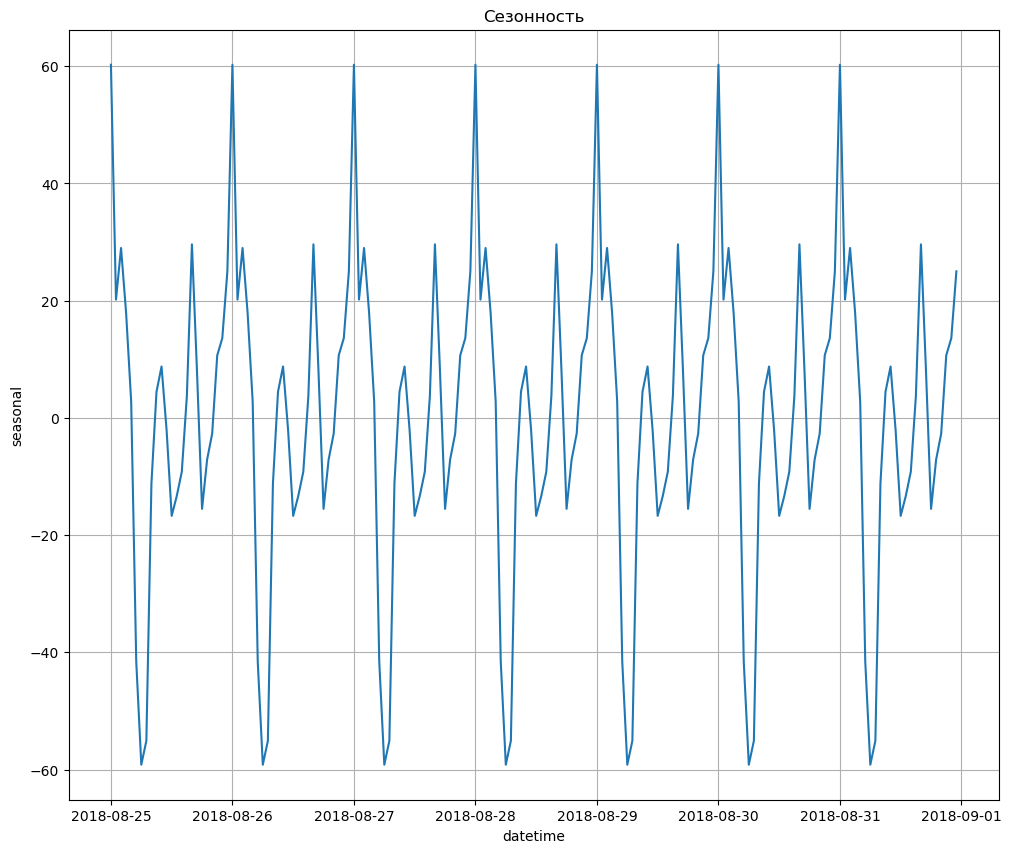

In [14]:
plot(decompose.seasonal.tail(24*7), 'Сезонность')

В течении дня присутствует периодичность

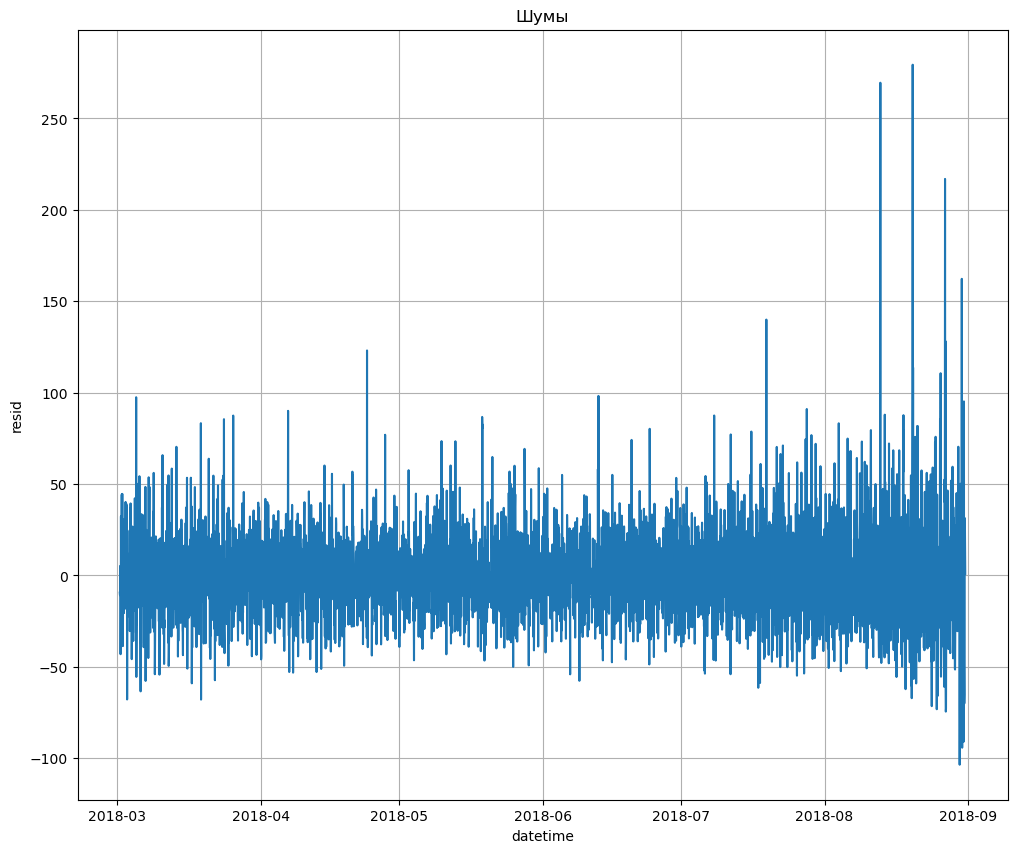

In [15]:
plot(decompose.resid, 'Шумы')

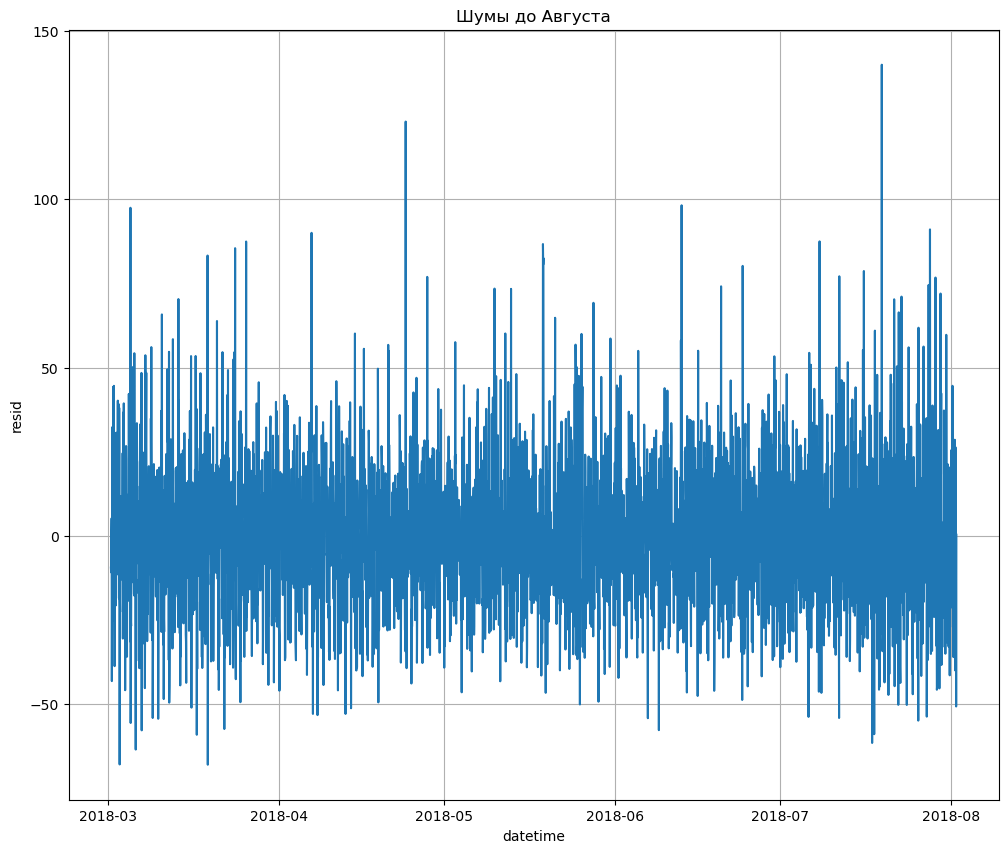

In [16]:
plot(decompose.resid[:'2018-08-01'], 'Шумы до Августа')

Шумов становится больше в конце исходного периода, наверное стоит убрать данные в августе, чтоб улучшить прогноз модели

In [17]:
def get_features(df):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, 6):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(1).mean()
    df.dropna(inplace=True)
    
    return df

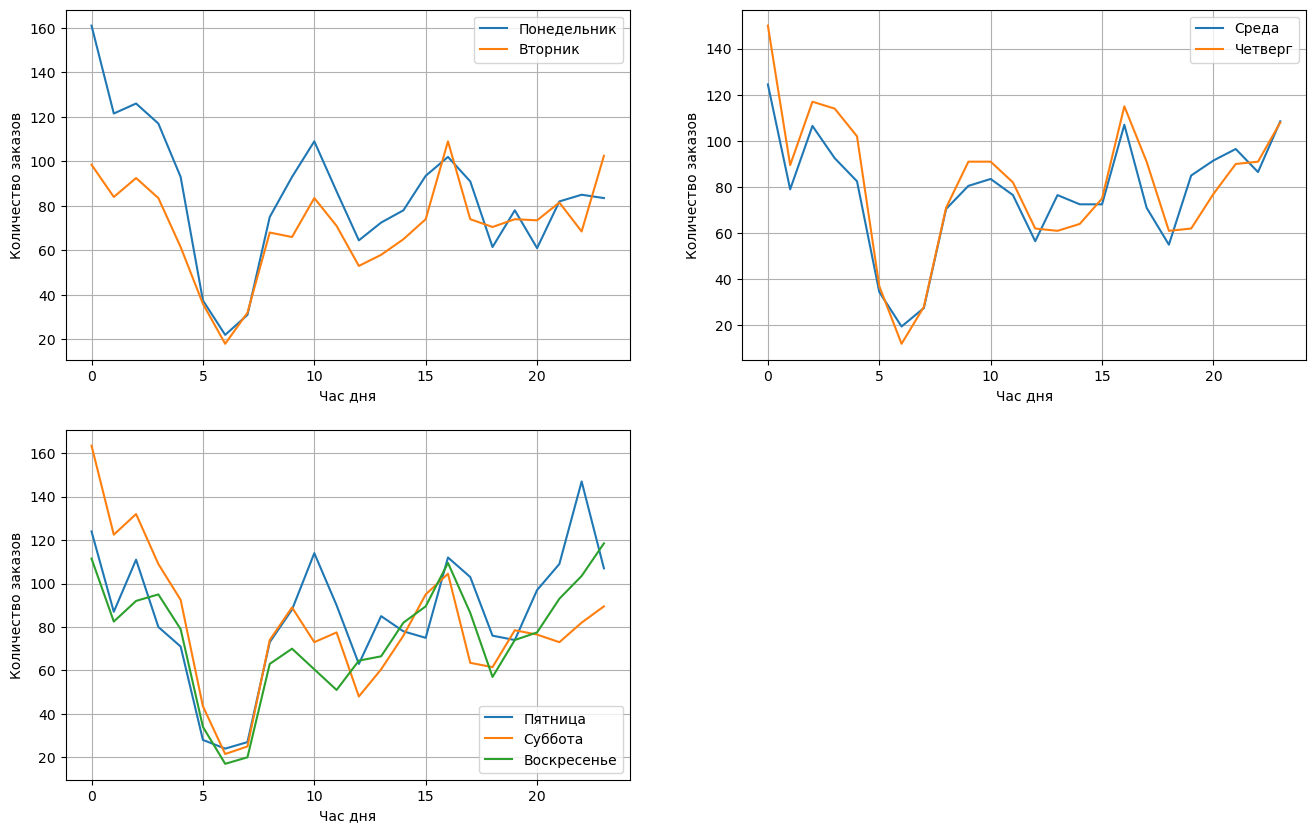

In [18]:
temp = get_features(df).pivot_table(index='hour', columns='dayofweek', values='num_orders', aggfunc='median')
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=temp, x=temp.index, y=0, label='Понедельник')
sns.lineplot(data=temp, x=temp.index, y=1, label='Вторник')
plt.ylabel('Количество заказов')
plt.xlabel('Час дня')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
sns.lineplot(data=temp, x=temp.index, y=2, label='Среда')
sns.lineplot(data=temp, x=temp.index, y=3, label='Четверг')
plt.ylabel('Количество заказов')
plt.xlabel('Час дня')
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
sns.lineplot(data=temp, x=temp.index, y=4, label='Пятница')
sns.lineplot(data=temp, x=temp.index, y=5, label='Суббота')
sns.lineplot(data=temp, x=temp.index, y=6, label='Воскресенье')
plt.ylabel('Количество заказов')
plt.xlabel('Час дня')
plt.legend()
plt.grid()

- В течении всех дней идет одна тенденция, больше всего заказов в 12 ночи потом идет резкое падение до минимума в 6 утра, повышение до 9-10 утра, потом падение до 14, увеличение до 16 часов, падение до 17 и после рост соответсвенно до 12 часов ночи

In [19]:
temp.describe()

dayofweek,0,1,2,3,4,5,6
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,84.375000,70.750000,77.354167,80.895833,85.125000,80.479167,74.895833
std,30.901404,21.359246,25.260159,30.570652,30.007698,31.926369,26.574333
min,22.000000,18.000000,19.500000,12.000000,24.000000,21.500000,17.000000
25%,70.500000,64.125000,70.875000,62.000000,73.750000,63.000000,62.375000
50%,84.250000,72.250000,79.750000,85.750000,86.000000,77.000000,78.250000
75%,95.625000,83.500000,91.750000,93.750000,107.500000,93.125000,92.250000
max,161.000000,109.000000,124.500000,150.000000,147.000000,163.500000,118.500000


- В среднем меньше всего заказов во вторник, среду и воскресенье
- В остальные дни недели среднее количество заказов не сильно различается

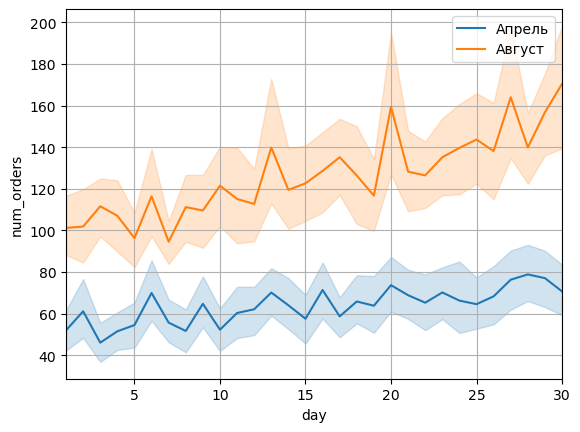

In [20]:
sns.lineplot(data=df[df.index.month == 4], x='day', y='num_orders', label='Апрель')
sns.lineplot(data=df[df.index.month == 8], x='day', y='num_orders', label='Август')
plt.xlim(1, 30)
plt.grid()

Мы получили график изменения количества заказов в двух месяцах Апрель и Август, как можно заметить количество заказов со временем увеличивается

**Промежуточные итоги**
- Восходящий тренд с шумами и с несколькими падения в течении всего периода, также видна ускорение тренда в августе
- Ряд стационарен
- В течении дня присутствует периодичность количества заказов
- Шумов становится больше в конце исходного периода
- В течении всех дней идет одна тенденция, больше всего заказов в 12 ночи потом идет резкое падение до минимума в 6 утра, повышение до 9-10 утра, потом падение до 14, увеличение до 16 часов, падение до 17 и после рост соответсвенно до 12 часов ночи
- Количество заказов со временем увеличивается

## Обучение моделей

### Подготовка данных

In [21]:
final_df = get_features(df).copy(deep=True)

In [22]:
features = final_df.drop('num_orders', axis=1)
target = final_df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=TEST_SIZE)

### RandomForest

In [23]:
%%time
RF = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': np.arange(50,100,10),
    'max_depth': np.arange(1, 12, 1),
    #'min_samples_split': np.arange(1, 10, 1)
             }
grid_search = GridSearchCV(
    RF, 
    param_grid, 
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(features_train, target_train)

CPU times: total: 3.17 s
Wall time: 33.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([50, 60, 70, 80, 90])},
             scoring='neg_root_mean_squared_error')

In [24]:
print('\nRandomForest с лучшими гиперпараметрами:\n', grid_search.best_estimator_)
print('Метрика RMSE:\n', -1*grid_search.best_score_)


RandomForest с лучшими гиперпараметрами:
 RandomForestRegressor(max_depth=11, n_estimators=90, random_state=42)
Метрика RMSE:
 27.361137153927


In [25]:
%%time
start = time()
RF = grid_search.best_estimator_
RF.fit(features_train, target_train)
end = time()
RF_fit_time = end - start

CPU times: total: 1.83 s
Wall time: 1.82 s


In [26]:
rmse_rf = -1*grid_search.best_score_
print(f'RandomForest RMSE: {rmse_rf}')

RandomForest RMSE: 27.361137153927


### CatBoost

In [ ]:
%%time
catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')
param_grid = {'depth':[None] + [i for i in range(2, 7)], 'learning_rate': np.arange(0.1, 1, 0.3)}
catboost_grid = catboost.grid_search(param_grid,
            Pool(features_train, target_train),
            cv=5,
            verbose=False,
            plot=False)

In [28]:
%%time
start = time()
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=0)
final_cat.fit(Pool(features_train, target_train))
end = time()
catboost_fit_time = end - start

CPU times: total: 14.9 s
Wall time: 2.89 s


In [29]:
rmse_catboost = catboost_grid['cv_results']['test-RMSE-mean'][-1]
print(f'CatBoost RMSE: {rmse_catboost}')

CatBoost RMSE: 24.152198409979796


### LightGBM

In [ ]:
%%time

param_grid = {'max_depth': np.arange(1, 12, 1), 
              'num_leaves': np.arange(20, 300, 20), 
              'learning_rate': np.arange(0.1, 1, 0.2)}
light = lgb.LGBMRegressor(random_state=RANDOM_STATE, force_row_wise=True)
randomized_search=RandomizedSearchCV(light,
                         param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=cv,
                         verbose=0,
                         n_jobs=-1)

randomized_search.fit(features_train, target_train)

In [31]:
print('\nLightGBM с лучшими гиперпараметрами:\n', randomized_search.best_estimator_)
print('Метрика RMSE:\n', -1*randomized_search.best_score_)


LightGBM с лучшими гиперпараметрами:
 LGBMRegressor(force_row_wise=True, max_depth=6, num_leaves=80, random_state=42)
Метрика RMSE:
 26.90419465537702


In [ ]:
%%time
start = time()

light = randomized_search.best_estimator_
light.fit(features_train, target_train)

end = time()
light_fit_time = end - start

In [33]:
rmse_light = -1*randomized_search.best_score_
print(f'Light: {rmse_light}')

Light: 26.90419465537702


In [34]:
models = pd.DataFrame({'Модель': ['RandomForest', 'Catboost', 'LightGBM'],
                       'RMSE при кросс-валидации': [rmse_rf, rmse_catboost, rmse_light],
                       'Время обучения в с.': [RF_fit_time, catboost_fit_time, light_fit_time]
                      })
models

,Модель,RMSE при кросс-валидации,Время обучения в с.
0,RandomForest,27.361137,1.822047
1,Catboost,24.152198,2.892228
2,LightGBM,26.904195,0.187598


**Промежуточный вывод**

- Была проведена кросс-валидация для трех моделей: RandomForest, CatBoost, LightGBM
- Лучшие гиперпараметры каждой модели были сохранены
- Модели были обучены на тренировочной выборке

## Тестирование моделей

In [35]:
%%time
start = time()
pred_catboost = final_cat.predict(features_test)

test_RMSE = mean_squared_error(target_test, pred_catboost)**0.5
print(f'RMSE на тестовой выборке лучшей модели: {test_RMSE}')
end = time()

catboost_test_predict = end - start

RMSE на тестовой выборке лучшей модели: 47.694520748545756
CPU times: total: 0 ns
Wall time: 6.98 ms


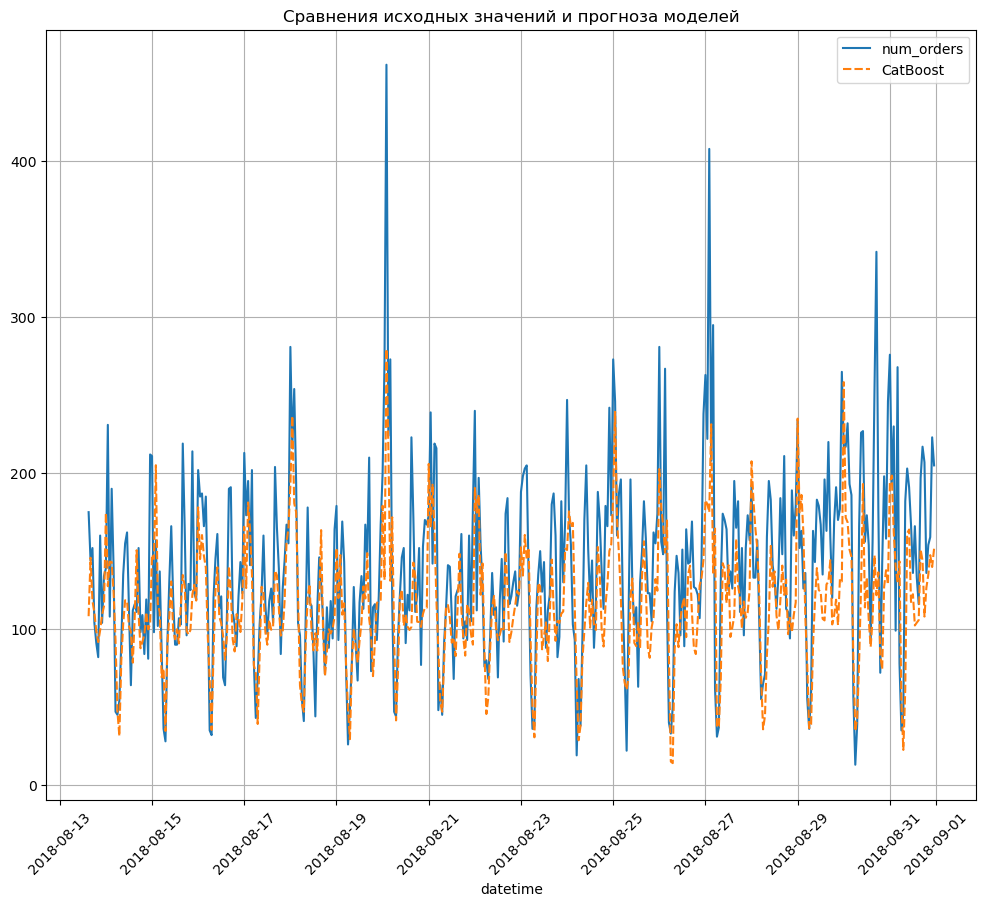

In [36]:
df_target = target.to_frame()
df_target['CatBoost'] = np.nan
df_target['CatBoost'][len(df_target)-len(pred_catboost):len(df_target)] = pred_catboost
plt.figure(figsize=(12, 10))
plt.xticks(rotation=45)
sns.lineplot(df_target[len(df_target)-len(pred_catboost):len(df_target)])
plt.grid()
plt.title('Сравнения исходных значений и прогноза моделей');

Рассматривая полученный график можно заметить, что CatBoost неплохо предсказывает пики по заказам, поэтому для задачи по предсказанию в моменты пиковой нагрузки, стоит использовать полученную модель

## Итоговый вывод
- Были обучены три модели: `RandomForest`, `CatBoost`, `LightGBM`, у каждой из которых метрика RMSE<48, при кросс-валидации
- Был проведен анализ и сравнение полученных моделей
- Был построен график исходных данных и прогноза моделей

**Исходя из полученных результатов, можно заключить, что из трех полученных моделей лучше всех в прогнозировании количества заказов справляет CatBoost, поскольку у нее самая низка метрика. Параметры модели представлены ниже**

In [37]:
print(f'CatBoost: {catboost_grid["params"]}')
print(f'Время обучения на тренировочной выборке: {catboost_fit_time}')
print(f'Время прогнозирования на тестовой выборке: {catboost_test_predict}')
print(f'RMSE на тестововой выборке: {test_RMSE}')

CatBoost: {'depth': 6, 'learning_rate': 0.1}
Время обучения на тренировочной выборке: 2.892228126525879
Время прогнозирования на тестовой выборке: 0.00698089599609375
RMSE на тестововой выборке: 47.694520748545756


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48